In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import paddle 
import paddle.nn as nn
import sklearn.metrics as metric

## 导入数据

In [25]:
data=pd.read_csv('data.csv')
c1=data[['c11','c12','c13']]
c2=data[['c21','c22','c23']]
c3=data[['c31','c32','c33']]
data_new=[c1,c2,c3]
train=[]
test=[]
for c,da in enumerate(data_new):
    for i in range(1,11):
        features=[]
        features.append(c)
        for j in da.iloc[i].values:
            features.append(j)
        if i>=8:
            test.append(features)
        else:
            train.append(features)
train=np.array(train,dtype=np.float64)
test=np.array(test,dtype=np.float64)
#打乱数据
np.random.shuffle(train)
np.random.shuffle(test)
print(len(test),len(train))

9 21


## 数据可视化

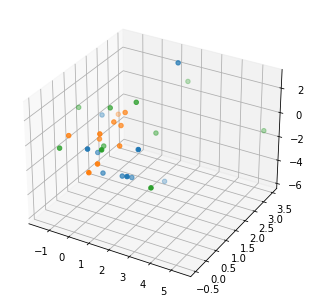

In [26]:
fig=plt.figure()
ax3d=Axes3D(fig)
for label,da in enumerate(data_new):
    x=da.iloc[1:,0].to_numpy().astype('float')
    y=da.iloc[1:,1].to_numpy().astype('float')
    z=da.iloc[1:,2].to_numpy().astype('float')
    ax3d.scatter(x,y,z,label=str(label))
plt.show()
    
    

## 直接使用神经网络

### 构建模型

In [27]:
class ANN(nn.Layer):
    def __init__(self,feature=3,hidden=7,class_dim=3,weight=None):
        super(ANN,self).__init__()#调用父类构造函数
        if weight is None:
            self.input_layer=nn.Linear(in_features=feature,out_features=hidden)
            self.hidden_layer=nn.Linear(in_features=hidden,out_features=class_dim)
        else:#如果输入了初始化参数，使用初始化参数
            weight_in2hid=paddle.framework.ParamAttr(initializer=nn.initializer.Assign(weight[0:feature*hidden].reshape([feature,hidden])))
            bias_in2hid=paddle.framework.ParamAttr(initializer=nn.initializer.Assign([weight[feature*hidden:feature*hidden+hidden]]))
            self.input_layer=nn.Linear(in_features=feature,out_features=hidden,weight_attr=weight_in2hid,bias_attr=bias_in2hid)
            weight_hid2out=paddle.framework.ParamAttr(initializer=nn.initializer.Assign(weight[feature*hidden+hidden:feature*hidden+hidden+hidden*class_dim].reshape([hidden,class_dim])))
            bias_hid2out=paddle.framework.ParamAttr(initializer=nn.initializer.Assign([weight[feature*hidden+hidden+hidden*class_dim:]]))
            self.hidden_layer=nn.Linear(in_features=hidden,out_features=class_dim,weight_attr=weight_hid2out,bias_attr=bias_hid2out)
        #self.hidden_layer_2=nn.Linear(in_features=7,out_features=class_dim)
        self.act_func=nn.ReLU()
        self.soft_max=nn.Softmax()
        #print(self.input_layer.parameters())
    
    def forward(self,x):
        x=self.input_layer(x)
        x=self.act_func(x)
        x=self.hidden_layer(x)
        #x=self.hidden_layer_2(x)
        out=x
        #out=self.soft_max(x)
        return out
model_summary=ANN()
print(paddle.summary(model_summary,(1,1,3)))
data_1 = paddle.ones(shape=[1, 3], dtype='float32')
print(model_summary(data_1))
    

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-5         [[1, 1, 3]]           [1, 1, 7]             28       
    ReLU-3          [[1, 1, 7]]           [1, 1, 7]              0       
   Linear-6         [[1, 1, 7]]           [1, 1, 3]             24       
Total params: 52
Trainable params: 52
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------------------------------

{'total_params': 52, 'trainable_params': 52}
Tensor(shape=[1, 3], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[-0.10516762,  0.39102787,  0.04002808]])


D:\anaconda3\envs\sunhuashan\lib\site-packages\paddle\tensor\random.py:466: DeprecationWarning: an integer is required (got type paddle.fluid.core_avx.VarType).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return core.ops.uniform_random('shape', shape, 'min',
D:\anaconda3\envs\sunhuashan\lib\site-packages\paddle\fluid\layers\tensor.py:675: DeprecationWarning: an integer is required (got type paddle.fluid.core_avx.VarType).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  core.ops.fill_constant(out, 'value',


### 训练模型

In [51]:
def train_function(model,train,lr=0.1,num_epochs=100):
    #paddle.set_device("gpu:0")
    model.train()
    #定义优化器和损失函数
    lossFunction=nn.CrossEntropyLoss()
    optimizer=paddle.optimizer.Adagrad(learning_rate=lr,parameters=model.parameters())

    step=0
    iters,loss_total,acc_total=[],[],[]

    for epo in range(num_epochs):
        for _,sample in enumerate(train):
            step+=1
            feature=paddle.to_tensor(sample[1:].reshape([1,3]),dtype='float32')
            #print(feature)
            label=paddle.to_tensor(sample[0],dtype='int64') 
            prediction=model(feature)
            prediction=paddle.reshape(prediction,(1,3))
            loss=lossFunction(prediction.astype('float64'),label)
            if step%50==0:
                iters.append(step)
                loss_total.append(loss.numpy()[0])
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            #print('epoch:{},loss:{}'.format(epo,loss.numpy()[0]))
    #print(loss_total)
    return np.mean(loss_total),np.min(loss_total),loss_total[-1]

In [42]:
def eval_func(model,test):
    model.eval()
    correct=0
    for sample_eval in test:
        feature=paddle.to_tensor(sample_eval[1:].reshape([1,3]),dtype='float32')
        label=paddle.to_tensor(sample_eval[0],dtype='int64')
        pre=model.forward(feature)
        if np.argmax(pre) == label :
            #print(np.argmax(pre),label)
            correct+=1
    #print('acc:{}'.format(correct/len(test)))
    return correct/len(test)
    

D:\anaconda3\envs\sunhuashan\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 建立遗传算法

In [44]:
class GA():
    def __init__(self,founction,m=9,n=52,eta=2,choice=3,iterration=200,p=0.2,mutation_ceta=5):
        self.founction=founction    #适应度评价函数
        self.m=m                    #种群规模
        self.n=n                    #个体编码长度
        self.eta=eta                #仿二进制基因交叉参数
        self.iteration=iterration   #种群迭代次数
        self.group=[]               #种群
        self.fitness=[]             #种群个体适应度
        self.mutation_p=p           #突变概率
        self.mutation_ceta=mutation_ceta #突变方差
        self.best_value=-1000000000000
        self.best_weight=[]
        self.history=[]
        self.choice=choice

    def group_creation(self):#初始化种群
        for i in range(self.m):
            entity=np.random.normal(size=self.n)#正态分布初始化个体
            self.group.append(entity)
    
    def fitness_computation(self,sombody=None):#计算种群适应度
        if sombody:
            return self.founction(sombody)
        self.fitness.clear()
        for entity in self.group:
            entity=np.array(entity)
            f=self.founction(entity)
            self.fitness.append(f[self.choice])
        
    def selection_1(self):#使用轮盘赌法进行选择
        sum=np.sum(self.fitness)
        fitness_p=[]#适应度概率
        fitness_p_cumulation=[]#累计函数
        #计算选取概率
        for f in self.fitness:
            fitness_p.append(f/sum)
        #计算积累概率
        p0=0
        for p in fitness_p:
            p0+=p
            fitness_p_cumulation.append(p0)
        #选择操作：
        i=0
        parents=[]
        while i<self.m:
            rp=np.random.uniform(0,1)#产生一个均匀分布的随机数
            for j in range(self.m):
                if fitness_p_cumulation[j]>rp:
                    break
            parents.append(self.group[j])
            i+=1
        return parents
    
    def selection_2(self):#使用比例法进行选择,将种群按大到小划分为3部分
        parents=[]
        
        return parents
    
    def select_beta(self):
        x=np.random.uniform(0,1)
        if x<=0.5:
            beta=(2*x)**(1/3)
        else:
            beta=1/(2-2*x)**(1/3)
        return beta

    def combination(self,parents):#基因交叉
        i=0
        children=[]
        while i <self.m:
            #随机选择两对父母
            x1=np.random.randint(0,self.m)
            x2=np.random.randint(0,self.m)
            entity1=parents[x1]
            entity2=parents[x2]
            child1=[]
            child2=[]
            for j in range(self.n):
                beta=self.select_beta()
                x_=(entity1[j]+entity2[j])/2
                child1.append(x_+beta*0.5*(entity1[j]-entity2[j]))
                child2.append(x_-beta*0.5*(entity1[j]-entity2[j]))
            children.append(child1)
            i+=1
            if i<self.m:
                children.append(child2)
                i+=1
        self.group=children.copy()
    
    def mutation(self):#突变算子
        for entity in self.group:
            for i in range(self.n):
                p=np.random.uniform(0,1)
                if p<self.mutation_p:#产生突变
                    entity[i]=entity[i]+np.random.normal(0,self.mutation_ceta)
    
    def run(self):
        self.group_creation()#初始化种群
        self.fitness_computation()#计算种群适应度
        for x in range(self.iteration):
            parents=self.selection_1()#选择父代
            self.combination(parents)#重组算子
            self.mutation()#突变算子
            self.fitness_computation()#计算种群适应度
            best=np.max(self.fitness)
            self.history.append(best)
            best_index=np.argmax(self.fitness)
            if self.best_value<best:
                self.best_value=best
                self.best_weight=list(self.group[best_index]).copy()
                #self.best_weight=list(self.group[self.fitness.index(best)]).copy()
            print("第{:}代，最佳适应度为{:}".format(x,best))
        print("the best one is %s"%self.best_value,self.best_weight)

    def get_best_one(self):
        return self.best_weight

In [45]:
def fitness_fuction(weight,train=train,test=test):
    model=ANN(weight=weight)
    loss_mean,loss_min,loss_last=train_function(model,train)
    fitness=eval_func(model,test)
    return [5.0-loss_mean,5.0-loss_min,5.0-loss_last,fitness]
    #假定weight有52位

## 开始算法

In [52]:
ga=GA(founction=fitness_fuction,m=9,n=52,eta=2,choice=3,iterration=50,p=0.2,mutation_ceta=5)
ga.run()

第0代，最佳适应度为0.7777777777777778
第1代，最佳适应度为0.6666666666666666
第2代，最佳适应度为0.5555555555555556
第3代，最佳适应度为0.5555555555555556
第4代，最佳适应度为0.6666666666666666
第5代，最佳适应度为0.5555555555555556
第6代，最佳适应度为0.6666666666666666
第7代，最佳适应度为0.6666666666666666
第8代，最佳适应度为0.6666666666666666
第9代，最佳适应度为0.7777777777777778
第10代，最佳适应度为0.6666666666666666
第11代，最佳适应度为0.6666666666666666
第12代，最佳适应度为0.6666666666666666
第13代，最佳适应度为0.7777777777777778
第14代，最佳适应度为0.6666666666666666
第15代，最佳适应度为0.7777777777777778
第16代，最佳适应度为0.6666666666666666
第17代，最佳适应度为0.5555555555555556
第18代，最佳适应度为0.6666666666666666
第19代，最佳适应度为0.6666666666666666
第20代，最佳适应度为0.6666666666666666
第21代，最佳适应度为0.6666666666666666
第22代，最佳适应度为0.6666666666666666
第23代，最佳适应度为0.6666666666666666
第24代，最佳适应度为0.6666666666666666
第25代，最佳适应度为0.6666666666666666
第26代，最佳适应度为0.6666666666666666
第27代，最佳适应度为0.7777777777777778
第28代，最佳适应度为0.8888888888888888
第29代，最佳适应度为0.8888888888888888
第30代，最佳适应度为0.8888888888888888
第31代，最佳适应度为0.8888888888888888
第32代，最佳适应度为0.8888888888888888
第33代，最佳适应度为1.0
第34代，

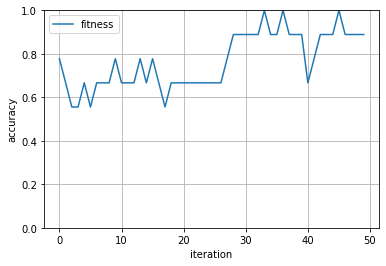

In [53]:
import matplotlib.pyplot as plt
x=range(len(ga.history))
plt.plot(x,ga.history,label='fitness')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid('--')
plt.ylim(0,1)
plt.legend()
plt.show()

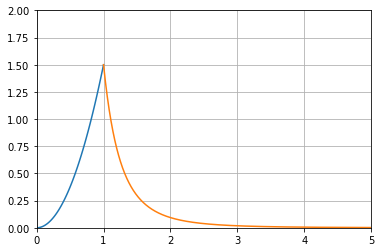

0.5*beta**3


In [ ]:
import sympy
import matplotlib.pyplot as plt
beta=sympy.symbols('beta')
func=1.5*beta**2
x=np.linspace(0,1,100)
y=1.5*x**2
plt.plot(x,y)
x1=np.linspace(1,5,1000)
y1=1.5*(1/(x1**4))
plt.plot(x1,y1)
plt.ylim(0,2)
plt.xlim(0,5)
plt.grid('--')
plt.show()
A=sympy.integrate(func,beta)
print(A)

D:\anaconda3\envs\sunhuashan\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


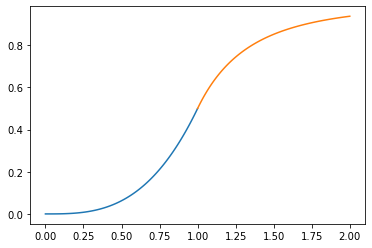

-0.5/beta**3


In [ ]:
import sympy
import matplotlib.pyplot as plt
beta=sympy.symbols('beta')
func=1.5*(1/(beta**4))
x=np.linspace(0,1,100)
y=0.5*x**3
plt.plot(x,y)
x1=np.linspace(1,2,100)
y1=-0.5/x1**3+1
plt.plot(x1,y1)
plt.show()
A=sympy.integrate(func,beta)
print(A)